In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arnysalazarcobian","key":"81cefa6371ffa6833c79b389168d6d34"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d arnysalazarcobian/perros-gatos#para dog-cat
!kaggle datasets download -d massielc/foxes-vs-zebras#para zebras-foxes

Dataset URL: https://www.kaggle.com/datasets/arnysalazarcobian/perros-gatos
License(s): unknown
 99% 36.0M/36.3M [00:03<00:00, 16.5MB/s]
100% 36.3M/36.3M [00:03<00:00, 11.2MB/s]


In [7]:
!unzip perros-gatos.zip -d /content/
#!unzip foxes-vs-zebras.zip -d /content/

Archive:  perros-gatos.zip
  inflating: /content/gatos_perros/test/cat/00357563a7.jpg  
  inflating: /content/gatos_perros/test/cat/029c926ce9.jpg  
  inflating: /content/gatos_perros/test/cat/057e6db146.jpg  
  inflating: /content/gatos_perros/test/cat/087d293433.jpg  
  inflating: /content/gatos_perros/test/cat/094ac674a9.jpg  
  inflating: /content/gatos_perros/test/cat/0b54dde5f5.jpg  
  inflating: /content/gatos_perros/test/cat/0c3d04bcf5.jpg  
  inflating: /content/gatos_perros/test/cat/0cfaf08fce.jpg  
  inflating: /content/gatos_perros/test/cat/0d0d6d90d8.jpg  
  inflating: /content/gatos_perros/test/cat/11883c3dd8.jpg  
  inflating: /content/gatos_perros/test/cat/124eecb74f.jpg  
  inflating: /content/gatos_perros/test/cat/15b23c04b7.jpg  
  inflating: /content/gatos_perros/test/cat/1a2dce7848.jpg  
  inflating: /content/gatos_perros/test/cat/1f016e1910.jpg  
  inflating: /content/gatos_perros/test/cat/2a40de8365.jpg  
  inflating: /content/gatos_perros/test/cat/2d7dc1ddb5.jpg

In [8]:
!pip install keras-vis
!pip install tensorflow

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator (antiguo)
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import activations

# Utility Functions

In [10]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    acc = smooth_curve(history.history['accuracy'][:steps])
    val_acc = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])

    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

# Building a Convolutional Neural Network

## Model Definition

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_2'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
#subir archivos
#from google.colab import files
#files.upload()

## Data Generator

In [23]:
base_dir = '/content/gatos-perros'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 120 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


## Training

In [24]:
history = model.fit(train_generator, steps_per_epoch=100, epochs=20,
                              validation_data=validation_generator, validation_steps=20, verbose=1)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.4374 - loss: 0.7101 - val_accuracy: 0.5083 - val_loss: 0.6923
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5544 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5171 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6898
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4667 - loss: 0.6943 - val_accuracy: 0.5500 - val_loss: 0.6884
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6755 - loss: 0.6846 - val_accuracy: 0.6167 - val_loss: 0.6722
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6122 - loss: 0.6751 - val_accuracy: 0.5167 - val_loss: 0.6664
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5153 - loss: 0.6640 - val_accuracy: 0.6500 - val_loss: 0.6019
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6666 - loss: 0.5955 - val_accuracy:

In [25]:
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

# Calcular el número de steps:
test_steps = len(test_generator)
results = model.evaluate(test_generator, steps=test_steps)

Found 120 images belonging to 2 classes.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9685 - loss: 0.0721


In [26]:
results ## --> loss, accuracy

[0.0911484956741333, 0.949999988079071]

In [27]:
#model.save('model.h5') --> legacy, ahora se usa .keras
model.save('model.keras')

In [28]:
save_history(history, 'history.bin')

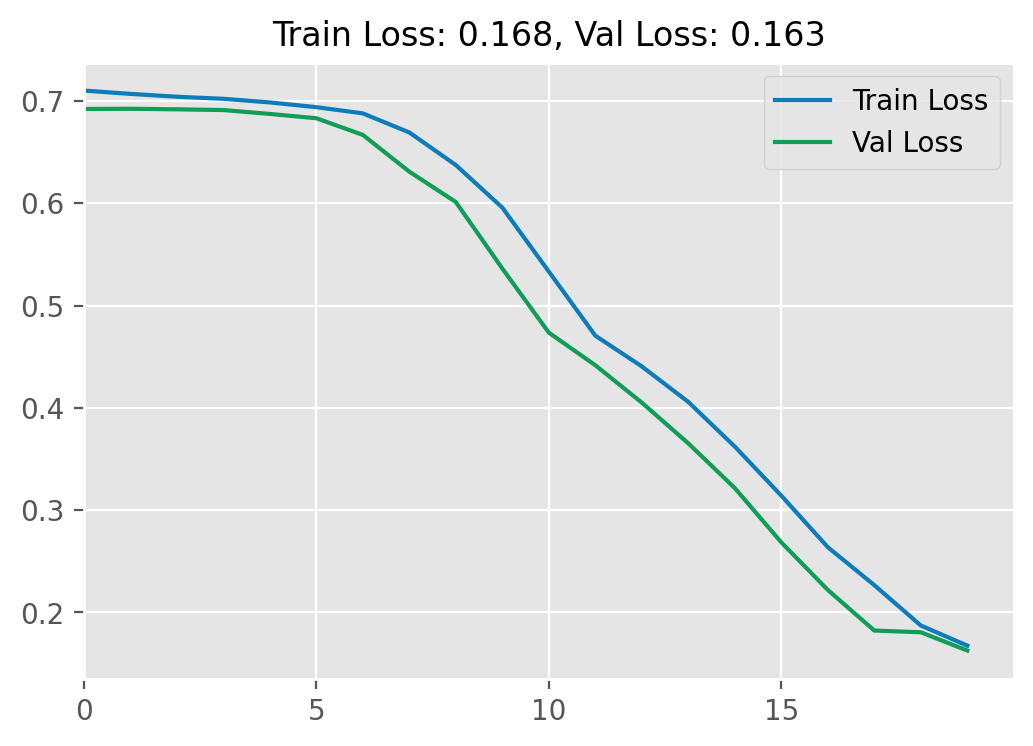

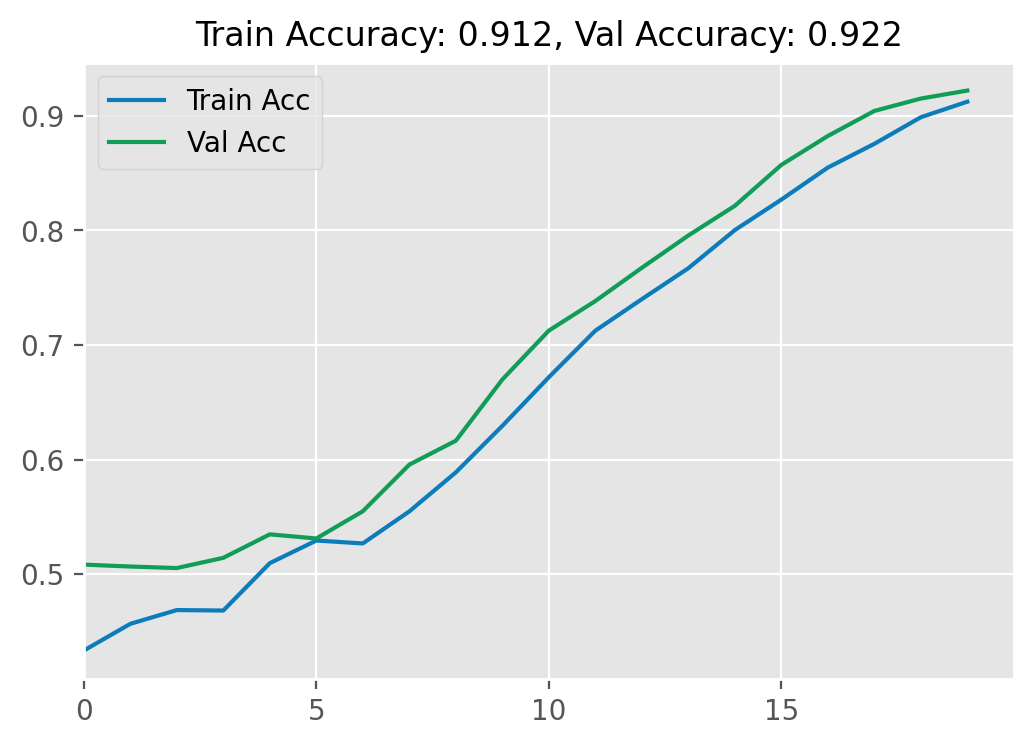

In [29]:
history = load_history('history.bin')
plot_compare(history)

## Data Augmentation

In [30]:
model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu', name='dense_1'))
model_aug.add(Dense(256, activation='relu', name='dense_2'))
model_aug.add(Dense(1, activation='sigmoid', name='output'))

In [31]:
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

# early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
history_aug = model_aug.fit(train_generator, steps_per_epoch=100, epochs=20,
                                      validation_data=validation_generator, validation_steps=20, verbose=0)

Found 120 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [33]:
model_aug.save('model_aug.keras')
save_history(history_aug, 'history_aug.bin')

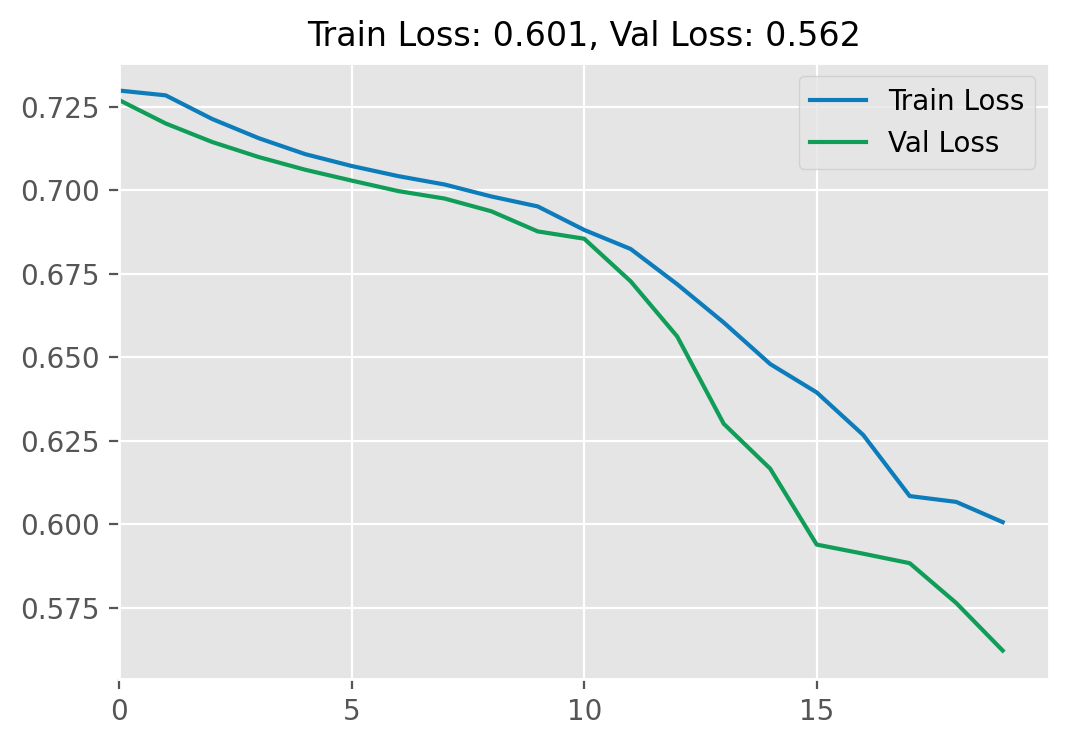

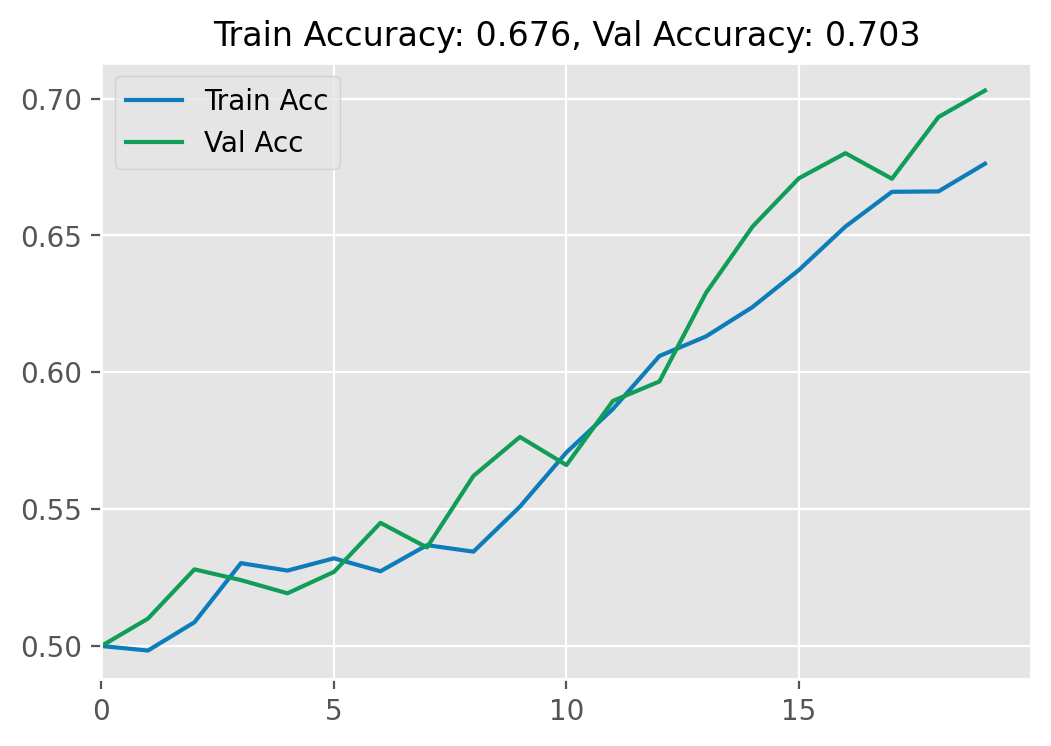

In [34]:
history_aug = load_history('history_aug.bin')
plot_compare(history_aug, steps=50)

In [35]:
# Calcular el número de steps:
results_aug = model_aug.evaluate(test_generator, steps=test_steps)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.7176 - loss: 0.5347


# Visualizing Feature Maps

In [37]:
img_path = '/content/gatos-perros/train/cat/0cfaf08fce.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


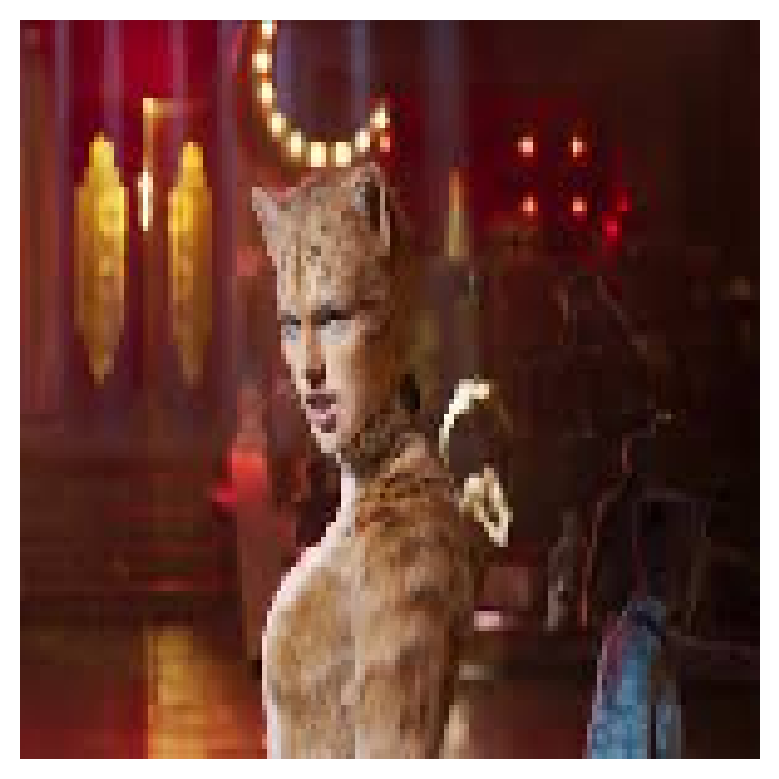

In [38]:
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

In [39]:
vgg = VGG16(weights='imagenet', include_top=False)
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


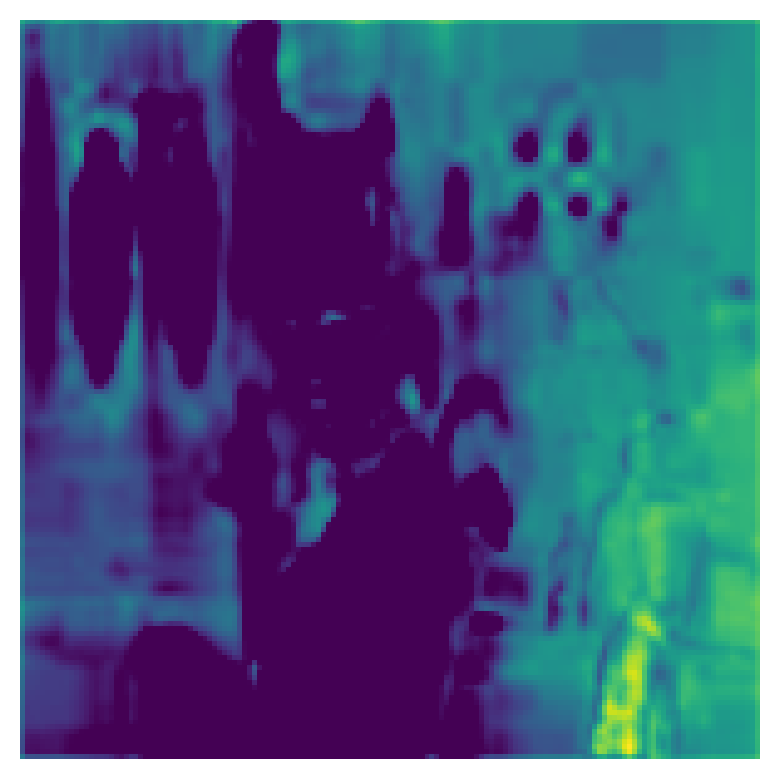

In [40]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in vgg.layers if 'conv1' in layer.name]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


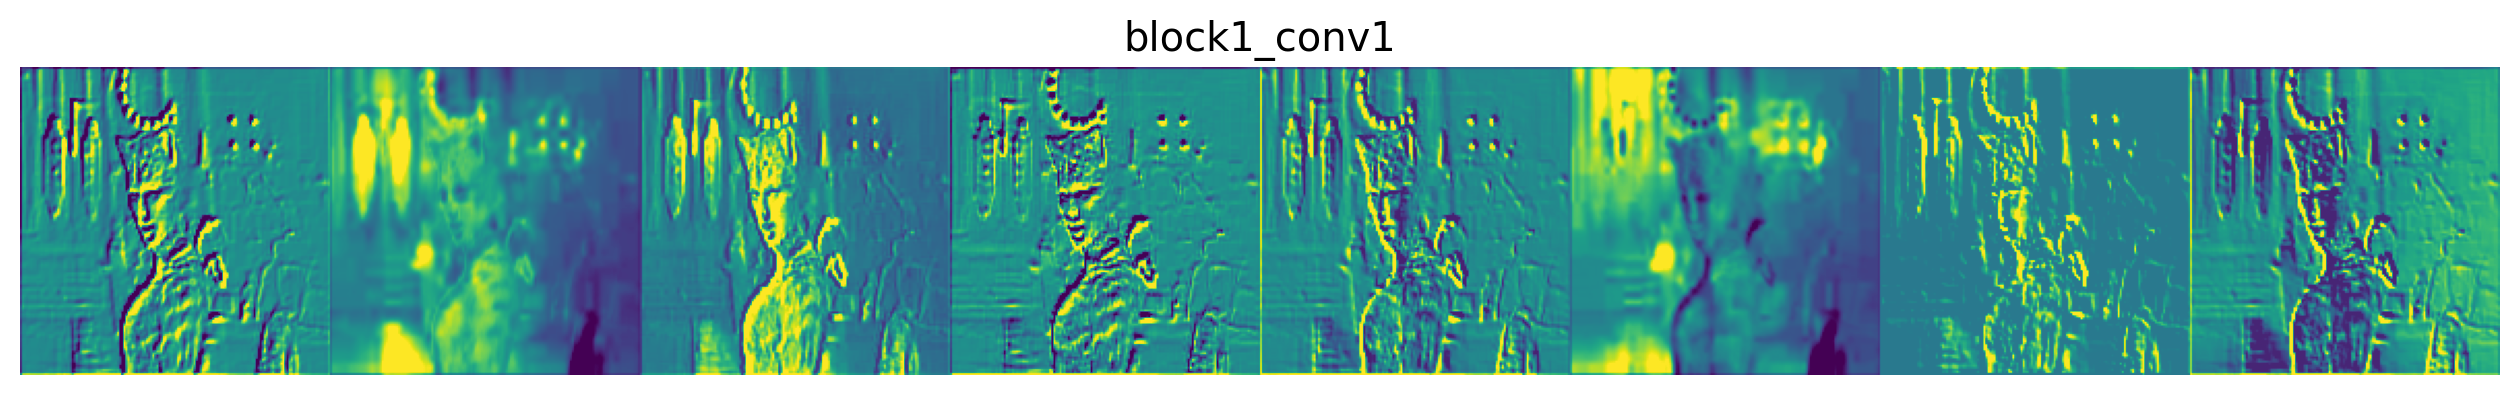

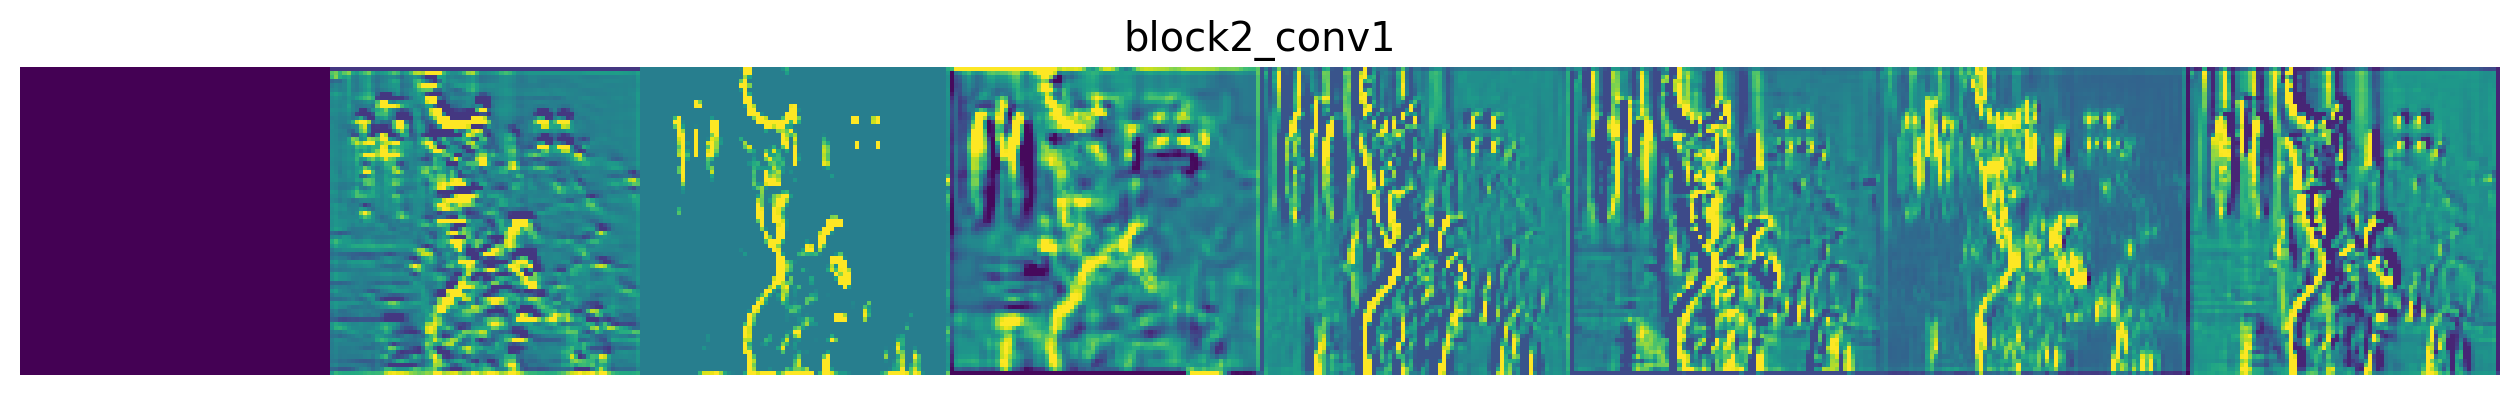

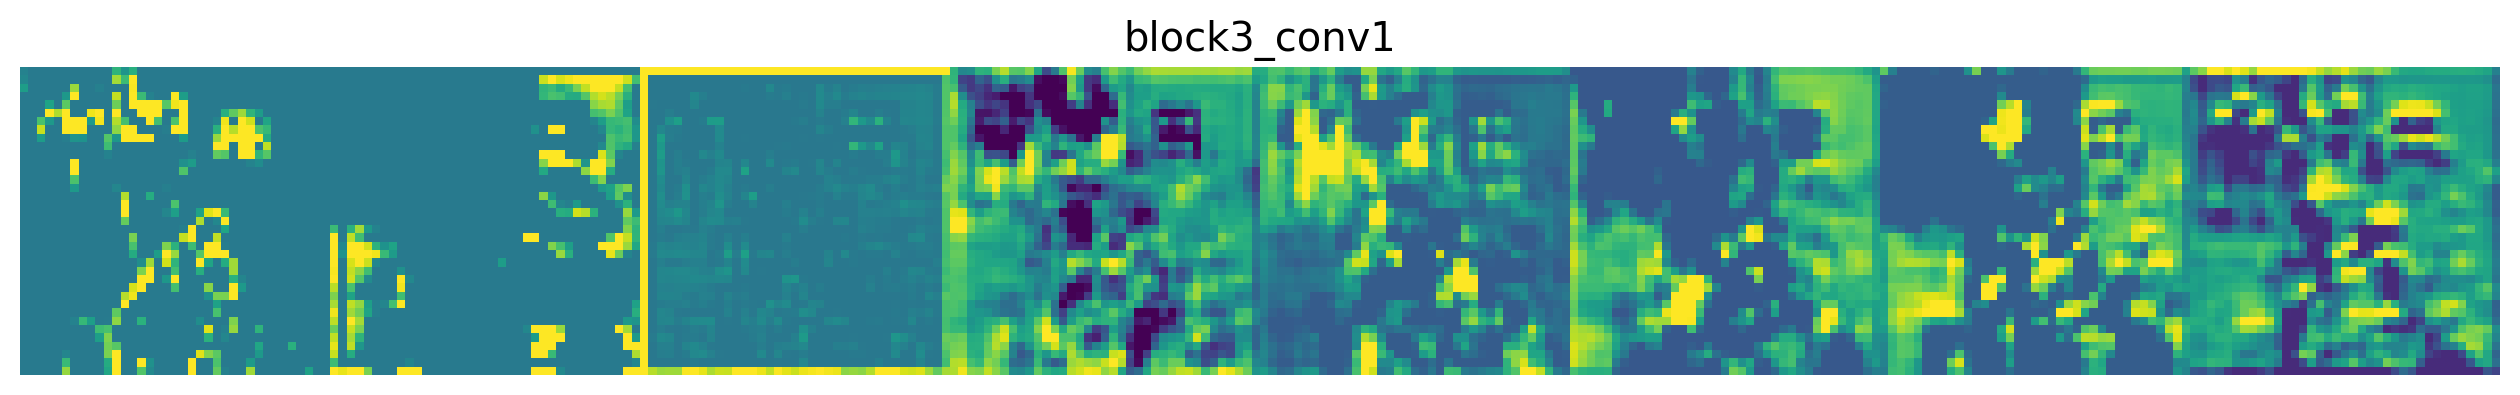

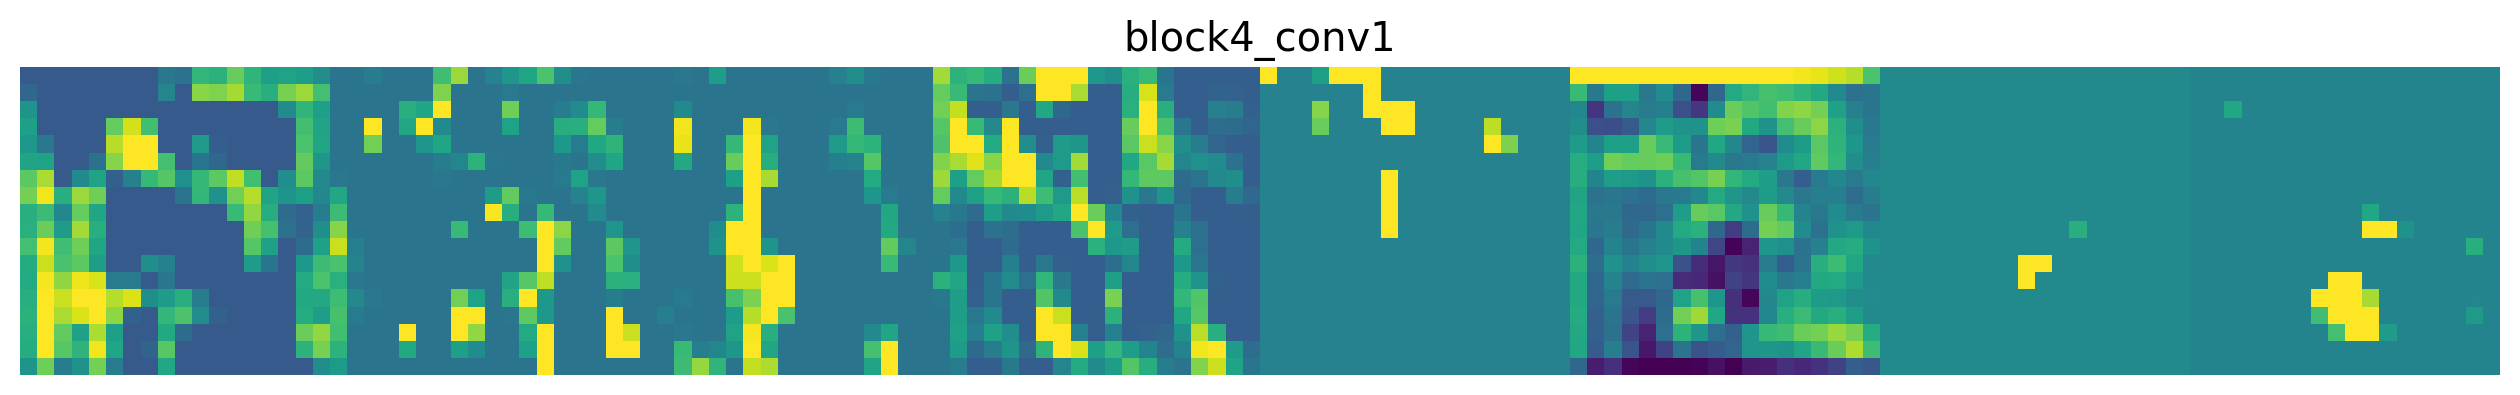

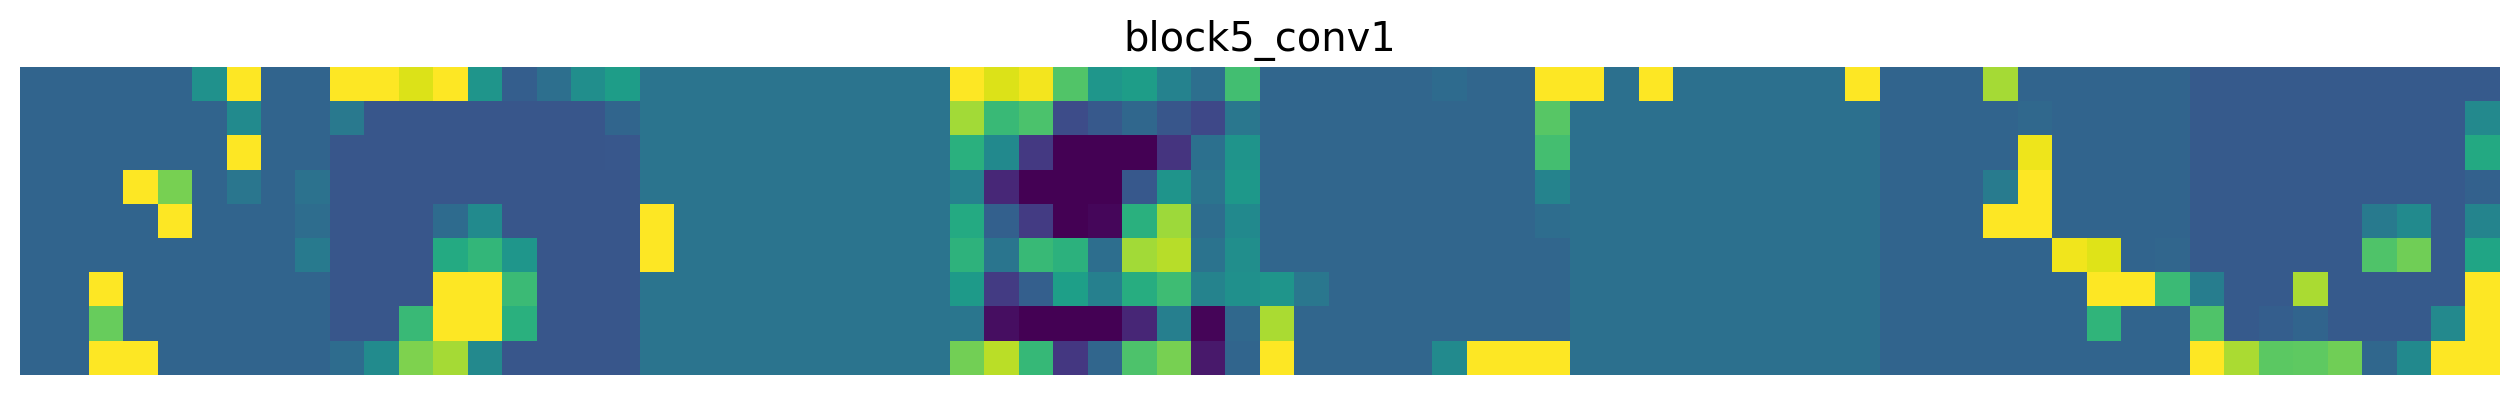

In [41]:
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

images_per_row = 8
max_images = 8
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, intermediate_activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

# Dense Layer Visualization

In [42]:
import inspect
import vis

# Obtener la ruta del archivo de la librería 'vis'
file_location = inspect.getfile(vis)
print(f"La librería 'vis' está ubicada en: {file_location}")

La librería 'vis' está ubicada en: /usr/local/lib/python3.10/dist-packages/vis/__init__.py


In [43]:
# Cambiar la línea que contiene 'from collections import Iterable'
file_path="/usr/local/lib/python3.10/dist-packages/vis/utils/utils.py"
line_number = 15  # Cambia esto al número de línea correcto
new_line = 'from collections.abc import Iterable\n'

# Reemplazar la línea en el archivo
with open(file_path, 'r') as file:
    lines = file.readlines()

lines[line_number - 1] = new_line

with open(file_path, 'w') as file:
  file.writelines(lines)

In [69]:
from vis.utils import utils
#from vis.visualization import visualize_activation, get_num_filters
#from vis.input_modifiers import Jitter

In [45]:
# Build the VGG16 network with ImageNet weights
model_2 = VGG16(weights='imagenet', include_top=True)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


In [46]:
# Utility to search for layer index by name.
layer_idx = utils.find_layer_idx(model_2, 'block1_conv1')
print(layer_idx)

1


In [47]:
model_2.summary() #include_top=True, que incluye la capa de clasificación final.

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Obtener la capa de salida
output_layer = model_2.layers[-1]

# Comprobar la activación
print(f"Nombre de la capa: {output_layer.name}")
print(f"Función de activación: {output_layer.activation}")

Nombre de la capa: predictions
Función de activación: <function softmax at 0x7fcdc77fb010>


# **Cambiar última capa a Activación Linear**
Cambiar a linear en la capa de salida permite optimizar la entrada para maximizar la activación del filtro

In [53]:
from tensorflow.keras import layers, models, activations

# Extraer todas las capas excepto la capa de salida
x = model.layers[-2].output  # Salida de la penúltima capa

# Crear una nueva capa de salida con activación lineal
predictions = layers.Dense(1000, activation='linear', name='predictions')(x)

# Crear un nuevo modelo con la capa de salida modificada
modified_model = models.Model(inputs=model_2.input, outputs=predictions)

In [54]:
# Ajusta el optimizador y la función de pérdida según sea necesario
modified_model.compile(optimizer='adam', loss='mean_squared_error')

In [55]:
# Obtener la capa de salida
output_layer = modified_model.layers[-1]

# Comprobar la activación de softmax --> linear
print(f"Nombre de la capa: {output_layer.name}")
print(f"Función de activación: {output_layer.activation}")

Nombre de la capa: predictions
Función de activación: <function linear at 0x7fcdc77fb6d0>


In [70]:
!pip install keras-vis

In [114]:
# 20 is the imagenet category for 'ouzel'
#img = visualize_activation(model_2, layer_idx, filter_indices=20)
#plot_image(img)

In [ ]:
# Jitter 16 pixels along all dimensions to during the optimization process.
#img = visualize_activation(model, layer_idx, filter_indices=20, max_iter=400, input_modifiers=[Jitter(16)])
#plot_image(img)

In [ ]:
#codes = '''
#rabbit 330
#crocodile 49
#starfish 327
#husky 248
#goldfish 1
#bridge 839
#balloon 417
#gondola 576
#tennis ball 852
#dumbbell 543
#hammer 587
#lamp 846
#'''

#initial = []
#images = []
#tuples = []
#for line in codes.split('\n'):
    #if not line:
        #continue
    #name, idx = line.rsplit(' ', 1)
    #idx = int(idx)
    #img = visualize_activation(model, layer_idx, filter_indices=idx,
                               #tv_weight=0., max_iter=300, input_modifiers=[Jitter(16)])

    #initial.append(img)
    #tuples.append((name, idx))

#i = 0
#for name, idx in tuples:
    #img = visualize_activation(model, layer_idx, filter_indices=idx,
                               #seed_input = initial[i], max_iter=300, input_modifiers=[Jitter(16)])
    #img = utils.draw_text(img, name)
    #i += 1
    #images.append(img)

#stitched = utils.stitch_images(images, cols=4)
#plt.figure(figsize=(20, 20))
#plt.axis('off')
#plt.imshow(stitched)
#plt.show()

# Visualizing Convnet Filters

In [ ]:
#max_filters = 40
#selected_indices = []
#vis_images = [[], [], [], [], []]
#i = 0
#selected_filters = [[0, 3, 11, 25, 26, 33, 42, 62],
    #[8, 21, 23, 38, 39, 45, 50, 79],
    #[40, 48, 52, 54, 81, 107, 224, 226],
    #[58, 79, 86, 216, 307, 426, 497, 509],
    #[2, 7, 41, 84, 103, 306, 461, 487]]

#for layer_name in ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']:
    #layer_idx = utils.find_layer_idx(model, layer_name)

    # Visualize all filters in this layer.
    #if selected_filters:
        #filters = selected_filters[i]
    #else:
        #filters = sorted(np.random.permutation(get_num_filters(model.layers[layer_idx]))[:max_filters])
    #selected_indices.append(filters)

    # Generate input image for each filter.
    #for idx in filters:
        #img = visualize_activation(model, layer_idx, filter_indices=idx, tv_weight=0.,
                                   #input_modifiers=[Jitter(0.05)], max_iter=300)
        #vis_images[i].append(img)

    # Generate stitched image palette with 4 cols so we get 2 rows.
    #stitched = utils.stitch_images(vis_images[i], cols=4)
    #plt.figure(figsize=(20, 30))
    #plt.axis('off')
    #plt.title(layer_name)
    #plt.imshow(stitched)
    #plt.show()
    #i += 1

In [ ]:
#new_vis_images = [[], [], [], [], []]
#i = 0
#for layer_name in ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']:
    #layer_idx = utils.find_layer_idx(model, layer_name)

    # Generate input image for each filter.
    #for j, idx in enumerate(selected_indices[i]):
        #img = visualize_activation(model, layer_idx, filter_indices=idx,
                                   #seed_input=vis_images[i][j], input_modifiers=[Jitter(0.05)])
        #img = utils.draw_text(img, 'Filter {}'.format(idx))
        #new_vis_images[i].append(img)

    #stitched = utils.stitch_images(new_vis_images[i], cols=4)
    #plt.figure(figsize=(20, 30))
    #plt.title(layer_name)
    #plt.axis('off')
    #plt.imshow(stitched)
    #plt.show()
    #i += 1

desde aca

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


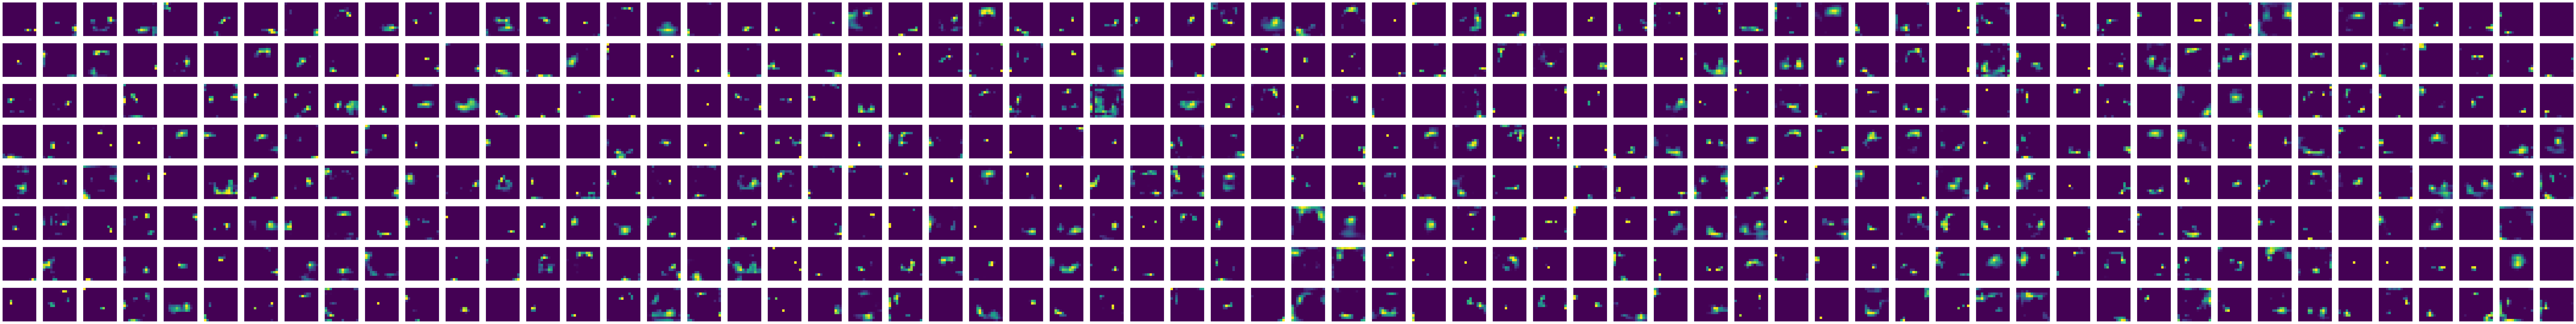

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras import backend as K

def visualize_activation(model, layer_name, input_image):
    """
    Visualize the activation of a specific layer for a given input image.
    """
    # Create a model that outputs the activations of the target layer
    layer_output = model.get_layer(layer_name).output
    activation_model = models.Model(inputs=model.input, outputs=layer_output)

    # Get the activations
    activations = activation_model.predict(np.expand_dims(input_image, axis=0))

    # Plot the activations
    num_filters = activations.shape[-1]
    size = activations.shape[1]
    num_cols = num_filters // 8
    num_rows = 8

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    for i in range(num_filters):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(activations[0, :, :, i], cmap='viridis')
        ax.axis('off')
    plt.show()


from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load a pre-trained model
model = VGG16(weights='imagenet', include_top=True)

# Load an image and preprocess it
img_path = '/content/gatos-perros/test/cat/15b23c04b7.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)

# Visualize the activation of a specific layer
layer_name = 'block5_conv3'  # Example layer name
visualize_activation(model, layer_name, img_array)

In [109]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Reemplaza 'ruta_a_tu_imagen.jpg' con la ruta a tu archivo de imagen.
img_path = '/content/WhatsApp Image 2024-09-01 at 22.13.47.jpeg'

# Cargar la imagen con tamaño 224x224, que es el tamaño esperado por VGG16.
img = image.load_img(img_path, target_size=(224, 224))

# Convertir la imagen a un array de numpy (con forma de 3 dimensiones: ancho, alto, canales de color).
img_array = image.img_to_array(img)

# Expandir dimensiones para tener la forma (1, 224, 224, 3) como VGG16 espera.
img_array = np.expand_dims(img_array, axis=0)

# Preprocesar la imagen para que sea compatible con el modelo VGG16 (normalización, etc.).
img_array = preprocess_input(img_array)


In [110]:
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions

# Cargar el modelo VGG16 preentrenado con pesos de ImageNet
model = VGG16(weights='imagenet')

# Hacer una predicción sobre la imagen
predictions = model.predict(img_array)

# Decodificar las predicciones para obtener nombres de clases legibles
decoded_predictions = decode_predictions(predictions, top=3)[0]
print("Predicciones:", decoded_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
Predicciones: [('n02441942', 'weasel', 0.98529583), ('n02443114', 'polecat', 0.01152434), ('n02442845', 'mink', 0.0028091988)]


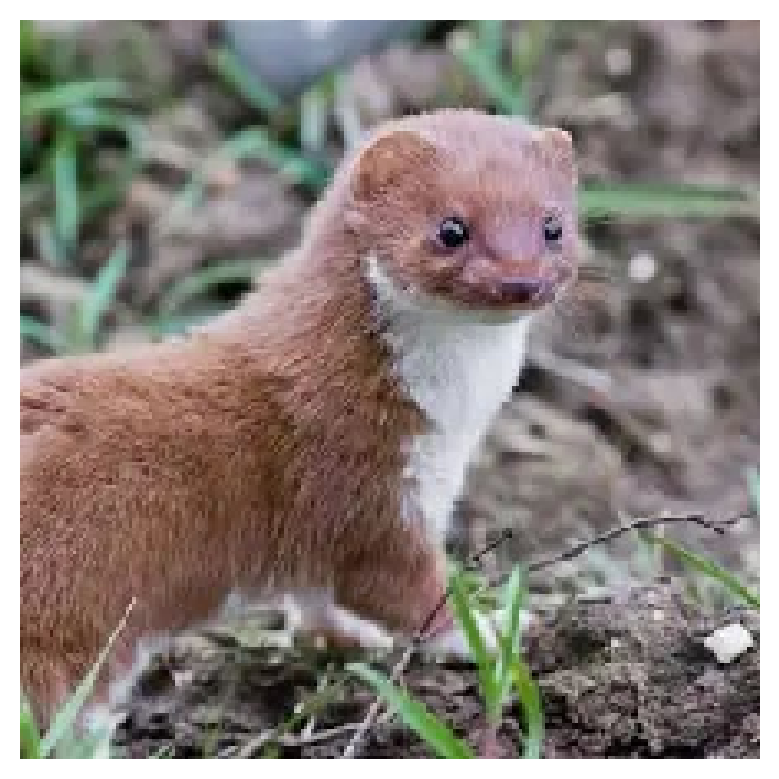

Predicción: weasel, Probabilidad: 0.985295832157135
Predicción: polecat, Probabilidad: 0.011524340137839317
Predicción: mink, Probabilidad: 0.0028091988060623407


In [111]:
import matplotlib.pyplot as plt

# Mostrar la imagen original
plt.imshow(image.load_img(img_path, target_size=(224, 224)))
plt.axis('off')
plt.show()

# Mostrar las predicciones
for pred in decoded_predictions:
    print(f"Predicción: {pred[1]}, Probabilidad: {pred[2]}")


200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - Score: 119.7620 - TotalVariation2D: 7.5835 - Norm: 7.9541


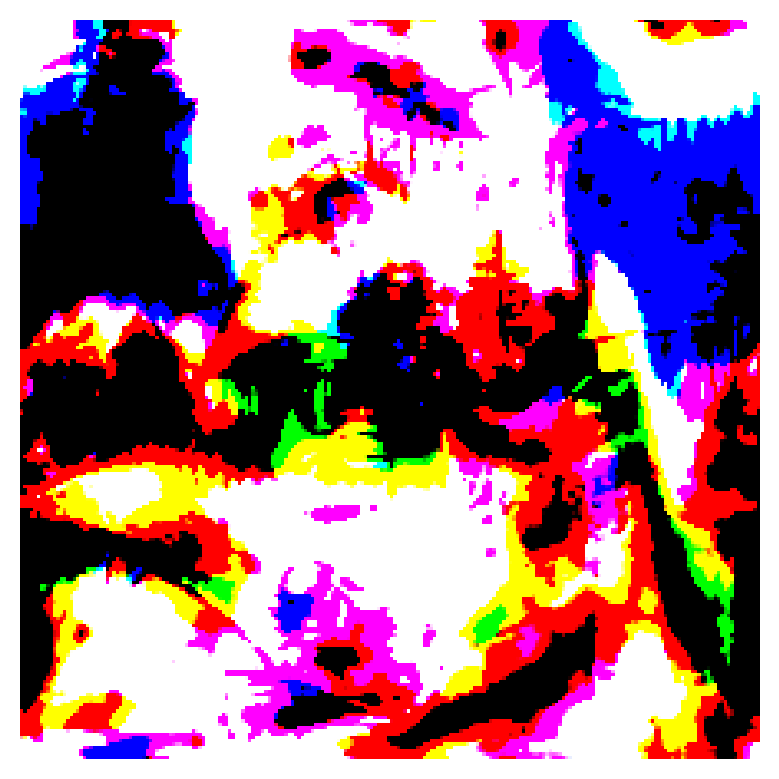

In [112]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress

# Reemplazar la última capa softmax por una capa lineal para visualización
replace2linear = ReplaceToLinear()

# Seleccionar una categoría específica para maximización de activación
# Puedes usar una categoría que haya sido predicha en el paso anterior
categoria_elegida = np.argmax(predictions)
score = CategoricalScore(categoria_elegida)

# Crear instancia de ActivationMaximization
activation_maximization = ActivationMaximization(model, model_modifier=replace2linear, clone=True)

# Visualizar las activaciones
activations = activation_maximization(score, seed_input=img_array, callbacks=[Progress()])

# Mostrar la imagen que maximiza la activación de la categoría seleccionada
plt.imshow(activations[0])
plt.axis('off')
plt.show()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - Score: 345.4503 - TotalVariation2D: 10.0716 - Norm: 8.6739


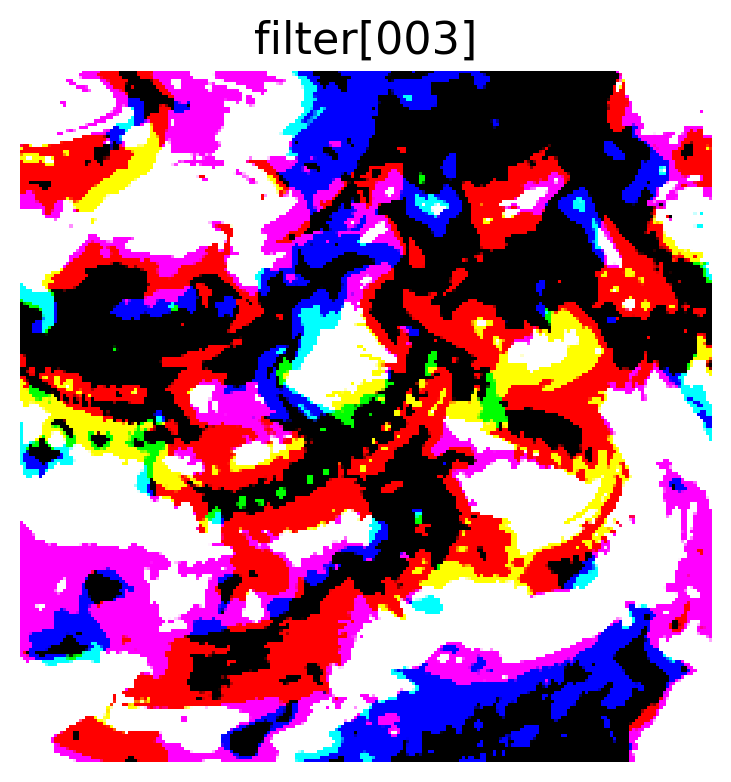

In [113]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress

# Cargar el modelo VGG16 preentrenado con pesos de ImageNet
model = Model(weights='imagenet', include_top=True)
model.summary()

# Modificar el modelo para que apunte a la capa de interés
layer_name = 'block5_conv3'  # Cambia esta capa si deseas visualizar una diferente
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=layer_name)
replace2linear = ReplaceToLinear()

# Crear instancia de ActivationMaximization
activation_maximization = ActivationMaximization(
    model,
    model_modifier=[extract_intermediate_layer, replace2linear],
    clone=False
)

# Función de puntuación para maximizar el filtro específico
filter_number = 3  # Cambia el número para visualizar otros filtros
score = CategoricalScore(filter_number)

# Cargar y preprocesar tu propia imagen
img_path = '/content/WhatsApp Image 2024-09-01 at 22.13.47.jpeg'  # Cambia esto a la ruta de tu imagen
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Utilizar la imagen cargada como seed_input
seed_input = img_array

# Generar activación maximizada
activations = activation_maximization(score, seed_input=seed_input, callbacks=[Progress()])

# Visualizar la activación
f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(activations[0])
ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()